In [69]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import color_palette

import pandas as pd 
import numpy as np
from dateutil.parser import parse

import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, output_file, show, curdoc
from bokeh.models import Circle,BoxSelectTool, BoxZoomTool, LassoSelectTool,Text,HoverTool,ColumnDataSource, Range1d, Axis

In [70]:
totals_pubs = pd.Series(index=pd.date_range('1950-01-01','2015-12-31',freq='AS',),data=[97529,102475,106673,108515,113949,100346,115704,122845,133961,137311,152292,179267,188095,196106,221271,288753,327167,349344,364851,399384,405709,420089,448565,459029,495345,566369,606671,683684,703905,728908,749425,775628,810977,875161,893747,893536,909200,920189,901468,856502,880419,901808,922010,963477,1015818,1080336,1130853,1159929,1161957,1187808,1205276,1189963,1234480,1270516,1356955,1434957,1495934,1567550,1655220,1716898,1750645,1836125,1913473,2005909,2027312,1809485,])
totals_refs = pd.Series(index=pd.date_range('1950-01-01','2015-12-31',freq='AS',),data=[862276,913941,991301,1054144,1082894,993625,1132516,1195067,1291857,1390632,1496650,1927193,2030321,2167335,2530307,3071105,3556047,3822576,4197118,4439659,4483020,4909395,5406217,5614448,5994449,6801509,7391424,7858516,8097995,8733158,9155748,9680861,10507381,11104584,11725145,12482330,12384351,12773481,13165658,13524406,14225948,15057108,15906821,16710320,17930450,19381008,21289915,22082648,22865217,23589060,24585765,25072234,26210739,27773579,29654550,31816766,34430852,36991583,40692695,43594503,46666951,50946087,55088628,59408651,62668029,59436898,])

In [71]:
df_refs = pd.read_pickle('/Users/jaredlorince/Desktop/d_pop_refs.pkl')
df_pubs = pd.read_pickle('/Users/jaredlorince/Desktop/d_pop.pkl')
df_keywords = pd.read_pickle('/Users/jaredlorince/Desktop/d_pop_keywords.pkl')

In [72]:
vc = df_keywords.groupby('keyword')['freq'].sum()
vc_df = vc[vc>=100].reset_index()
df_keywords=df_keywords.join(vc_df.set_index('keyword'),on='keyword',how='inner',rsuffix='_')

In [73]:
df_pubs = df_pubs.reset_index().pivot_table(index='date',columns='category',values='uid').fillna(0).ix[:'2015']
df_refs = df_refs.reset_index().pivot_table(index='date',columns='category',values='cnt').fillna(0).ix[:'2015']
df_keywords = df_keywords.pivot_table(index='date',columns='keyword',values='freq').fillna(0).ix[:'2015']

In [74]:
df_keywords.head()

keyword,'little ice age','t hooft and polyakov loops,(+)-catechin,(-)-alpha-kainic acid,(-)-deprenyl,(-)-epicatechin,(-)-epigallocatechin gallate,(-)-epigallocatechin-3-gallate,(-)-sparteine,(-)deprenyl,...,zymogen,zymogen activation,zymogen granules,zymogram,zymography,zymomonas mobilis,zymomonas-mobilis,zymosan,zyxin,zz-ceti stars
date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1952-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df_keywords.shape

(61, 176296)

In [78]:
#totals = df.sum(1)
cum_totals_pubs = totals_pubs.cumsum()
cum_totals_refs = totals_refs.cumsum()

In [ ]:
#top = df.sum().sort_values(ascending=False).index

In [79]:
output_notebook()



def update(rawcount=True,cumulative=False,resample='yearly',discipline='genomics',data_type='pubs'):
    def do_plot():
        df = globals()['df_'+data_type]
        #totals = globals()['totals_'+data_type]
        totals = totals_pubs
        #cum_totals = globals()['cum_totals_'+data_type]
        cum_totals = cum_totals_pubs
        lines = {}
        hovers = {}
        data = {}
        colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("coolwarm",n_colors=len(discipline)))).astype(int)]
        for i,disc in enumerate(discipline):
            current = df[disc].resample(resample).sum()
            totals_current = totals.resample(resample).sum()

            if cumulative:
                cum_totals_current = cum_totals.resample(resample).sum()
                if rawcount:
                    values = current.cumsum()
                else:
                    values = current.cumsum()/cum_totals_current
            else:
                totals_current = totals.resample(resample).sum()
                if rawcount:
                    values = current
                else:
                    values = current/totals_current
            data[disc] = ColumnDataSource({'x':idx,'value':values,'date':datestrings,'percent':{False:values.apply(lambda x: "{:.2f}%".format(100*x)),True:values.apply(lambda x: "{:,.0f}".format(x))}[rawcount]})
            lines[disc] = p.line('x','value',source=data[disc],color=colors[i],line_width=2)
            hovers[disc] = HoverTool(renderers=[lines[disc]],tooltips=[('Discipline', disc),('date','@date'),('{} this period'.format(data_type),'@percent')])
            p.add_tools(hovers[disc])
            if data_type == 'keywords':
                p.set(x_range=Range1d(parse('1990-01-01'), parse('2016-01-01')))
    if discipline == 'all':
        discpline = df.columns
    else:
        discipline = discipline.strip().split('|')
        
    p = figure(width=800,height=350,x_axis_type='datetime',tools=['pan,box_zoom,reset'])
    p.select(dict(type=Axis, layout="left"))[0].formatter.use_scientific = False
    resample = {'Daily':'D','Weekly':'W','Monthly':'M','Yearly':'A'}[resample]
    freq = {'D':'D','W':'W','M':'MS','A':'AS'}[resample]
    idx = pd.date_range('1950-01-01','2015-12-31',freq=freq)
    datestrings = idx.map(lambda x: x.strftime('%Y-%m-%d'))
    if data_type == 'both':
        for data_type in ('pubs','refs'):
            do_plot()#data_type,discipline,p,resample,cumulative,rawcount)
    else:
        do_plot()#data_type,discipline,p,resample,cumulative,rawcount)
    show(p)
    




Loading BokehJS ...

In [80]:
from ipywidgets import Dropdown,Text,Checkbox,interact

disc_select = Text(description='Discipline',value='Psychology')
rawcount_select = Checkbox(description = 'rawcount',value=True)
cumulative_select = Checkbox(description='cumulativ',value=False)
resample_select = Dropdown(description="Resample",options=["Daily","Weekly","Monthly","Yearly"],value="Yearly")
data_select = Dropdown(description="Data",options=["pubs","refs","keywords","both"],value="keywords")



interact(update,rawcount=rawcount_select,cumulative=cumulative_select,
         disc=disc_select,resample=resample_select,data_type=data_select);


In [275]:
'|'.join([x for x in df.columns if 'psych' in x.lower()])

'Psychiatry|Psychology|Psychology, Applied|Psychology, Biological|Psychology, Clinical|Psychology, Developmental|Psychology, Educational|Psychology, Experimental|Psychology, Mathematical|Psychology, Multidisciplinary|Psychology, Psychoanalysis|Psychology, Social'

In [ ]:
x = df.resample('AS').sum().cumsum().T
'|'.join(x.index[(x['2000']<10000).ix[:,0]])

In [222]:
#Genetics & Heredity|Mathematical & Computational Biology|Medical Informatics
totals.sum()

1066017645

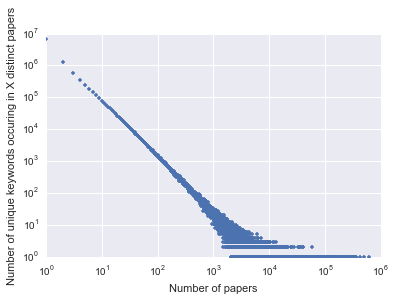

In [108]:
x=vc.value_counts().reindex(xrange(1,x.index.max()+1)).fillna(0)
fig,ax = plt.subplots(1,1)
ax.plot(x.index,x.values,ls='',marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of papers')
ax.set_ylabel('Number of unique keywords occuring in X distinct papers')

In [114]:
#vc[vc>=100].sort_values(ascending=False)
[k for k in vc.index if ('agent-based' in k]

['agent-based',
 'agent-based algorithm',
 'agent-based algorithms',
 'agent-based ambient intelligence applications',
 'agent-based analysis',
 'agent-based ant colony optimisation',
 'agent-based applications',
 'agent-based approach',
 'agent-based approach and system',
 'agent-based approaches',
 'agent-based architecture',
 'agent-based artificial chemistry',
 'agent-based artificial market',
 'agent-based artificial stock market',
 'agent-based artificial stock markets',
 'agent-based assistance',
 'agent-based brokerage',
 'agent-based chemotherapy',
 'agent-based cloud computing',
 'agent-based cognitive mapping system (abcms)',
 'agent-based collision avoidance (ca)',
 'agent-based compatibility',
 'agent-based complex systems',
 'agent-based computation',
 'agent-based computational approach',
 'agent-based computational auction design',
 'agent-based computational economic',
 'agent-based computational economics',
 'agent-based computational economics (ace)',
 'agent-based c